In [1]:
import numpy as np
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
matplotlib.use("pgf")
import matplotlib.pyplot as plt
import time
from requests import get
import zipfile, io
import os
import random
import math
import pickle
from IPython import display
import torch.nn.utils.parametrizations as param
%matplotlib inline


from model import make_model
from dataset_generator import dataset_generator
from utilities import generate_head_layer_ablations, FixedExamples, svd, PCA_plot, plot_attention_patterns, Relative_Angle_AfterFFN, Relative_Angle_AfterAttention, PCA_plot_different

device = 'cpu'

plt.rcParams.update({
        "pgf.texsystem": "pdflatex",
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Helvetica",
        'pgf.rcfonts': False,
    })

plt.style.use('seaborn-v0_8-ticks')

matplotlib.rcParams.update({'font.size': 18})

# Encoder only models analysis

<font size = '3'> Below is how we dealt with the different kinds of ablations. It is a bit cumbersome, but hopefully you will manage.  </font>

In [2]:
### Ablation specification

## Attention 

### The function generate_head_layer_ablations generates the set of all possible combinations of heads that can be ablated. 
# Pick one of these an use it for ab_head. Then specify with n_ab_head what layer you want to apply that ablation to. 
# The list ab_headrow is used in conjuction with M_apply. If M_apply is true, ab_headrow will be used and will ablate a specific row of the attention pattern.
# Again n_ab_head determines what layer this ablation is applied to. 

n_ab_head = [] # Specifies of what layer we want to apply zero-ablation to.
ab_head = [[1, 1], [1, 1]] # Specifies what head to ablate. This is a tensor of size (n, heads) with a 0 for those heads that you want to ablate, otherwise entries are one.
ab_headrow = [] # Specifies what row within a head we want to apply zero-ablation to.
M_apply = False # Specifies to whether to apply row-wise ablation or not. If True, use n_ab_head to set what layers you want the row-wise ablation to apply to.


ablation_attention = [M_apply, n_ab_head, ab_head, ab_headrow]

# FFN

List_Neurons = [] # List of neurons in the final layer you want to ablate.

ablation_ffn = List_Neurons

## Decoder 

n_ab_ffn = [] # Specifies which layer you want to ablate the FFN of. 
n_ab_att = [] # Specifies which layer you want to ablate the entire attention of. 

ablation_decoder = [n_ab_att, n_ab_ffn]

ablations = [ablation_attention, ablation_ffn, ablation_decoder]

Data generation, outputs input data, target data and the vocabulary. 

In [3]:
data_f, target_f, stoi = dataset_generator(P_f = 1000)

# Load model

<font size="3">Using the parameters (n, s, w, p) you can load different models used in the text </font>

In [7]:
n = 2 # Number of layers
s = 0.3 # Train/test split
w = 0.2 # weight decay
p = 2 # Specifies which of the six models to consider. In this block used as a dummy variable, but can be specified later on. 

vocab = 12

d_ff = 128
d_model = 128
heads = 2
dropout = 0.1

directory = 'n{!s}_s{!s}_w{!s}/'.format(n, s, w)
mdd = 'model_n{!s}_s{!s}_w{!s}_{!s}'.format(n, s, w, p)
toLoad = directory + mdd

model = make_model(vocab, N = n, d_model = d_model, d_ff = d_ff, h = heads, dropout = dropout, ablation_data = ablations)
model.load_state_dict(torch.load(toLoad, map_location='cpu'))
model.eval()

mask = None

# Data_out = []

# for p in range(6):
#     inputFile = 'DATA_n{!s}_s{!s}_w{!s}_{!s}.data'.format(n, s, w, p)
#     inputFile = directory + inputFile
#     fd = open(inputFile, 'rb')
#     Data_out.append(pickle.load(fd))

# T = len(Data_out[0][0])
# print(len(Data_out[0])) # Number of timeseries per model: train/test loss, train/test accuracy, average attention patterns after each epoch, weight norm squared

print('# of parameters =', sum(p.nelement() for p in model.parameters())) # number of parameters in total
print('Training set size =', len(data_f)*s) 

Q = generate_head_layer_ablations(n, heads)

# of parameters = 201996
Training set size = 150150.0


Generate a set of examples with a given outcome and vocabulary. 

In [8]:
examples = FixedExamples(74, stoi)

# Depending on what model you loaded, this generates 
# n = 2, s = 0.3, w = 0.2, p = 2 -> Fig. 3 and Fig. 4
# n = 1, s = 0.3, w = 0.2, p = 0 -> Fig. 7

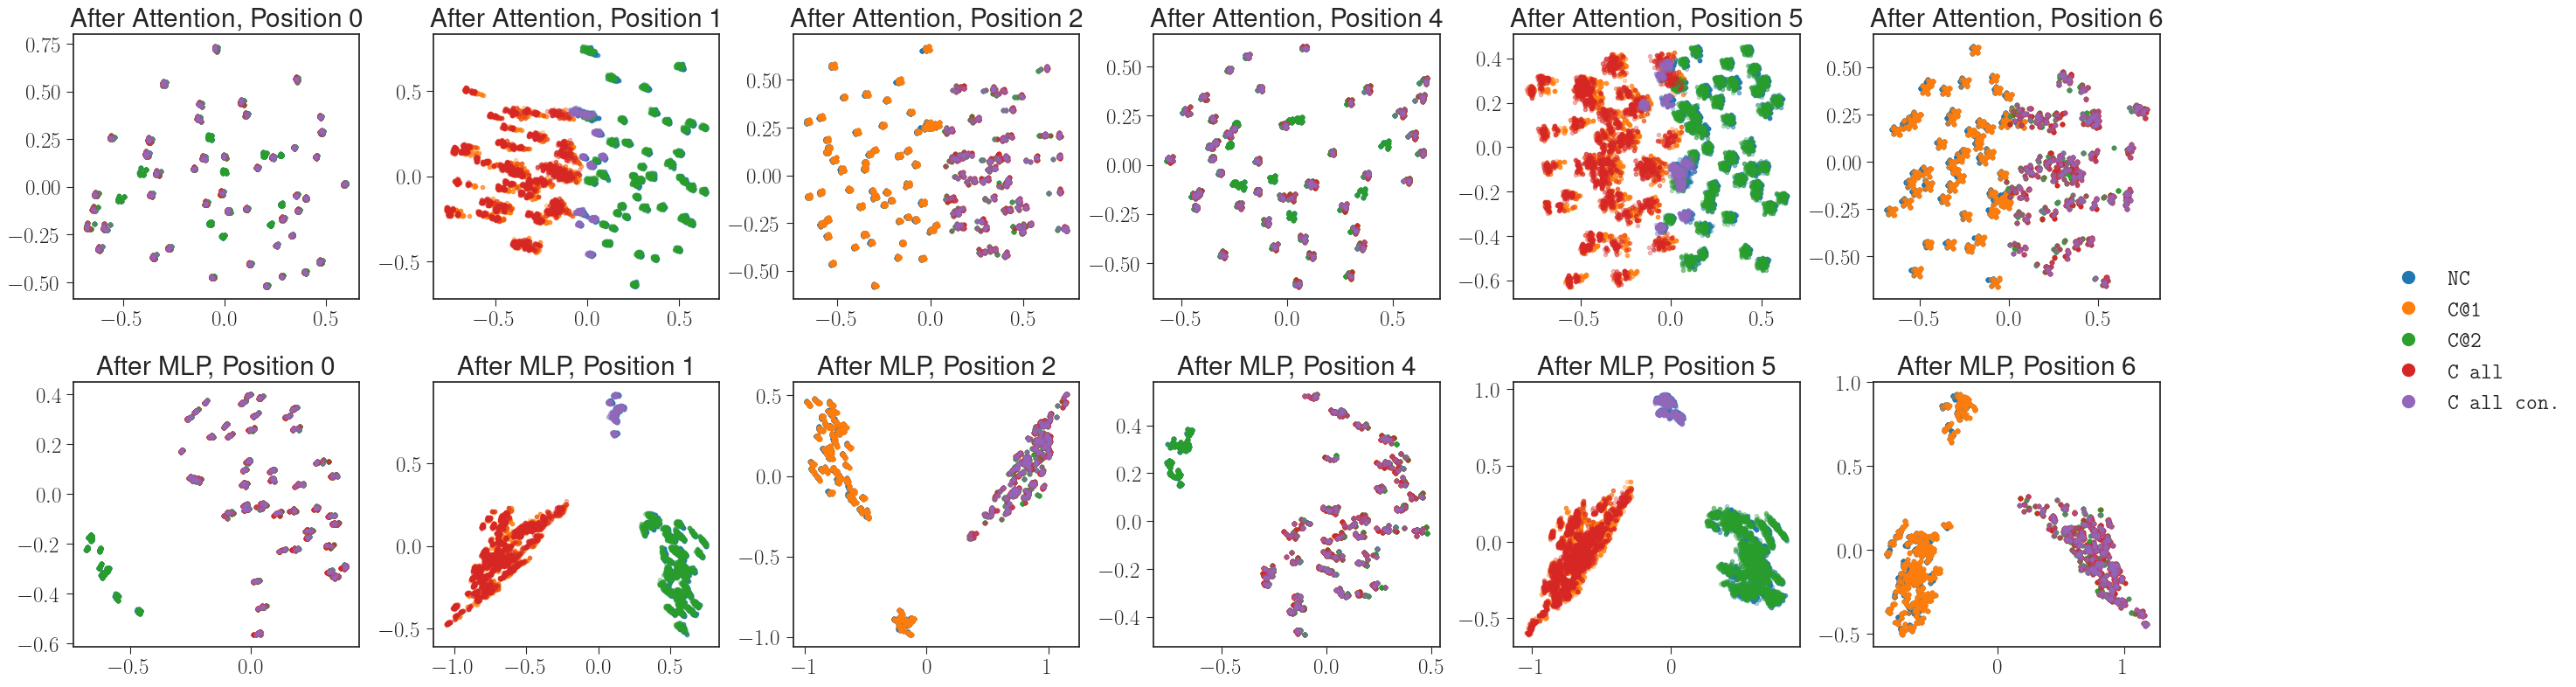

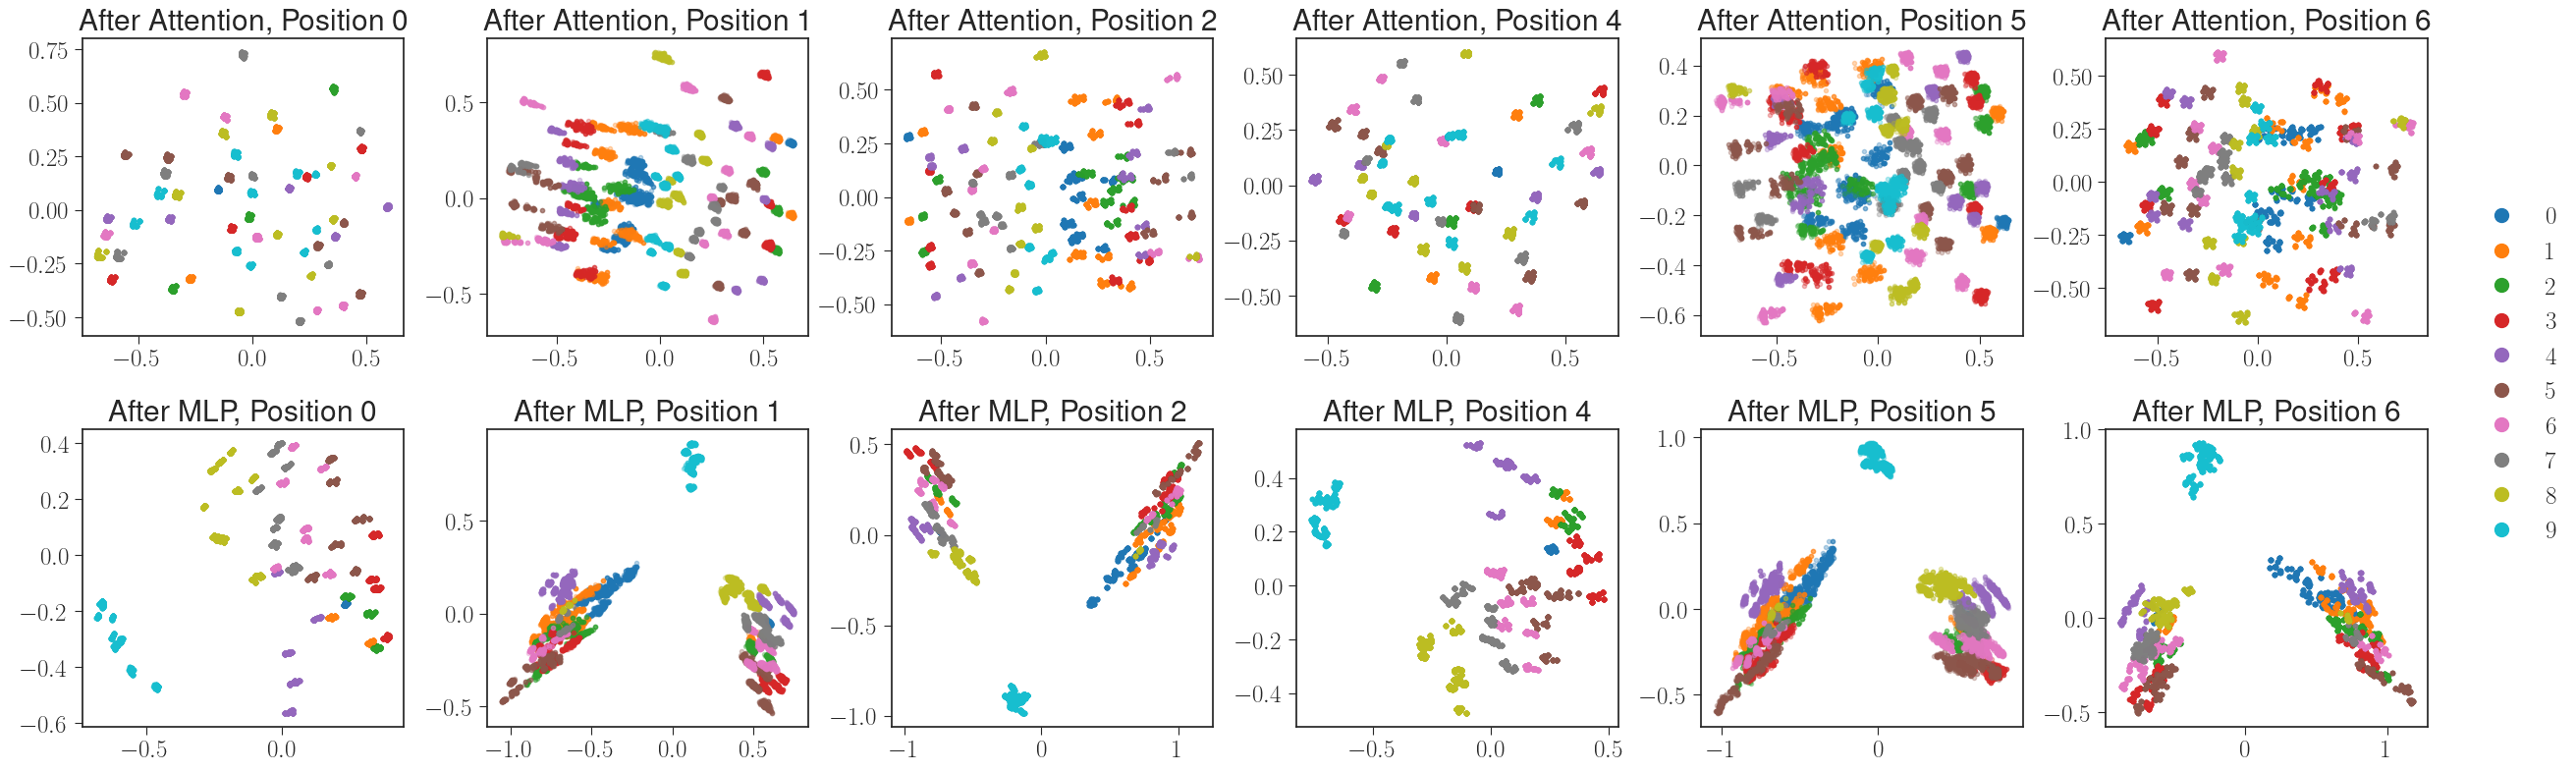

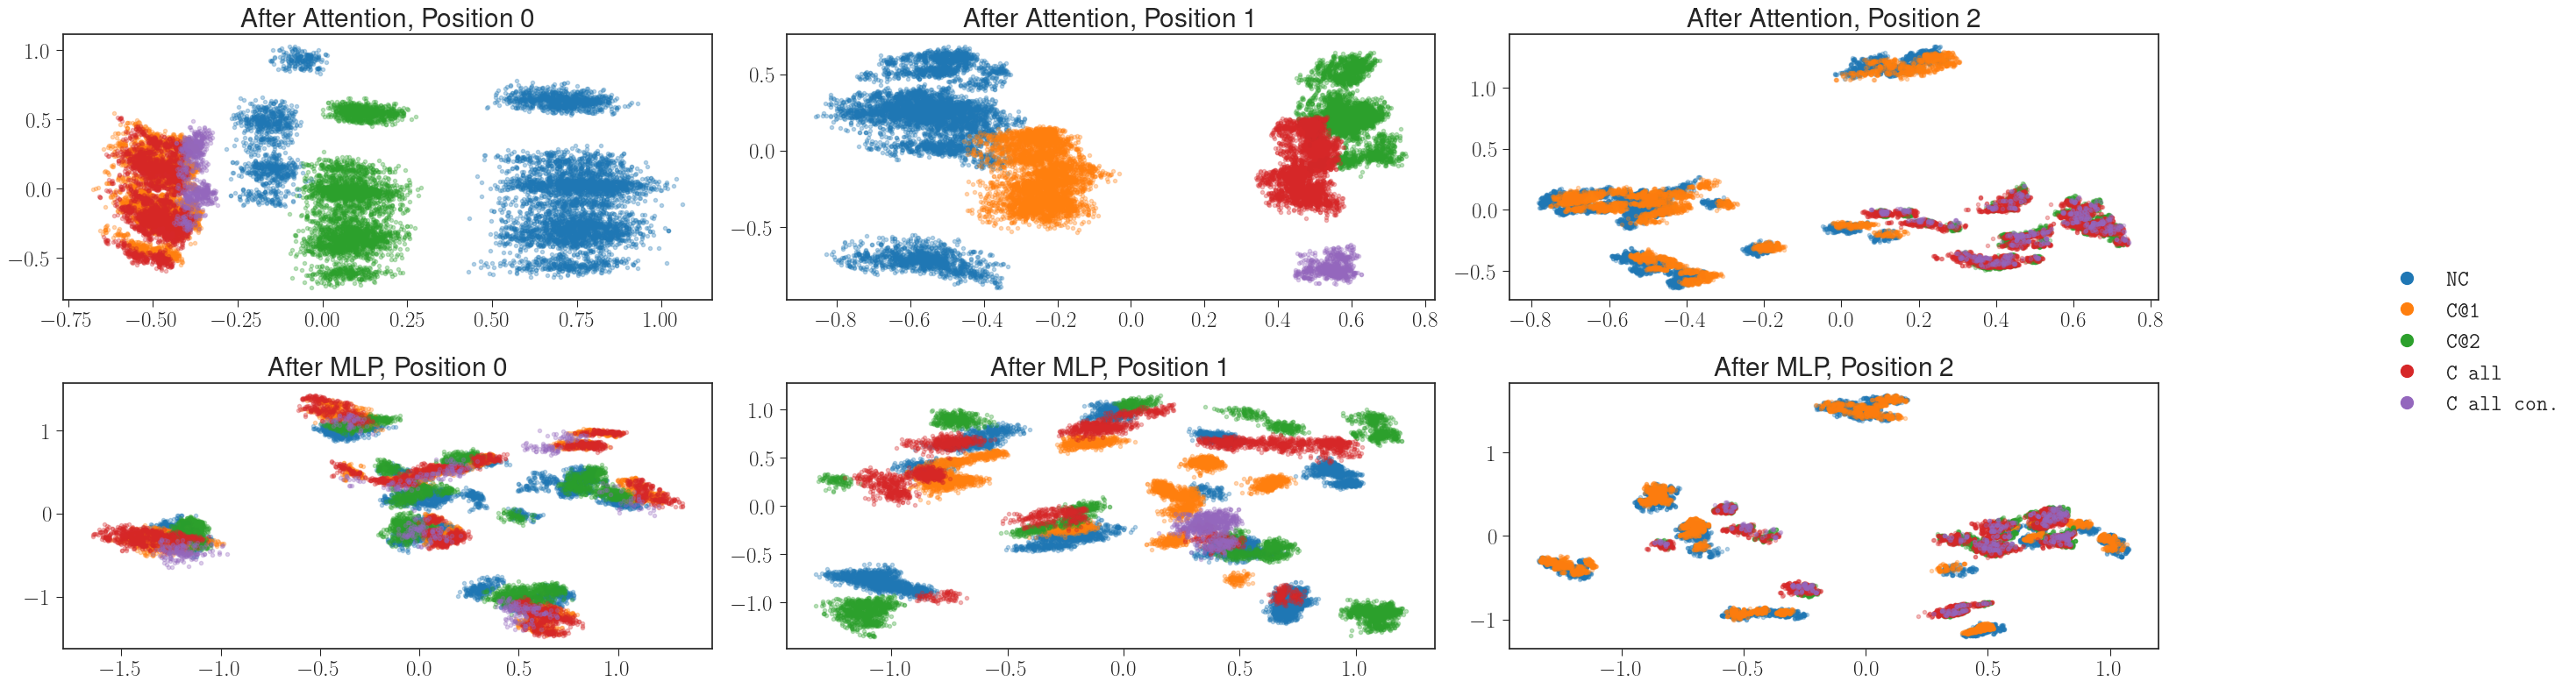

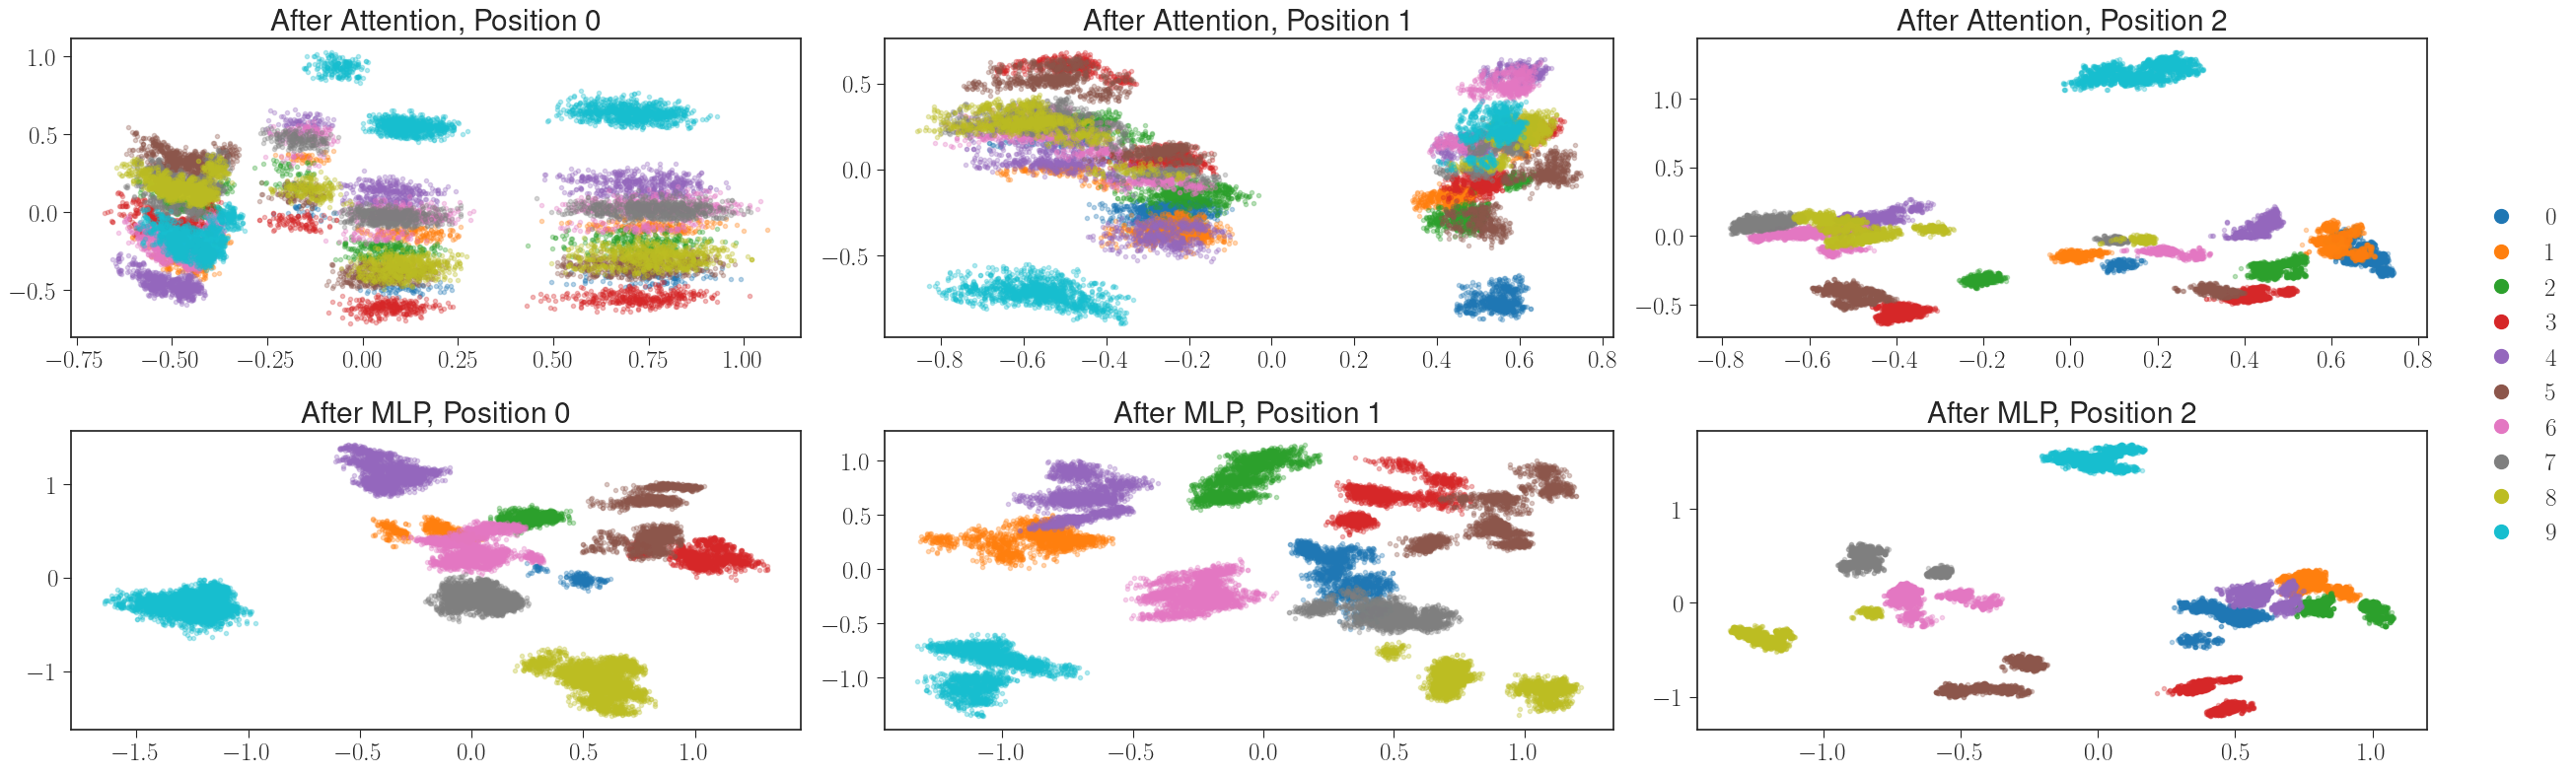

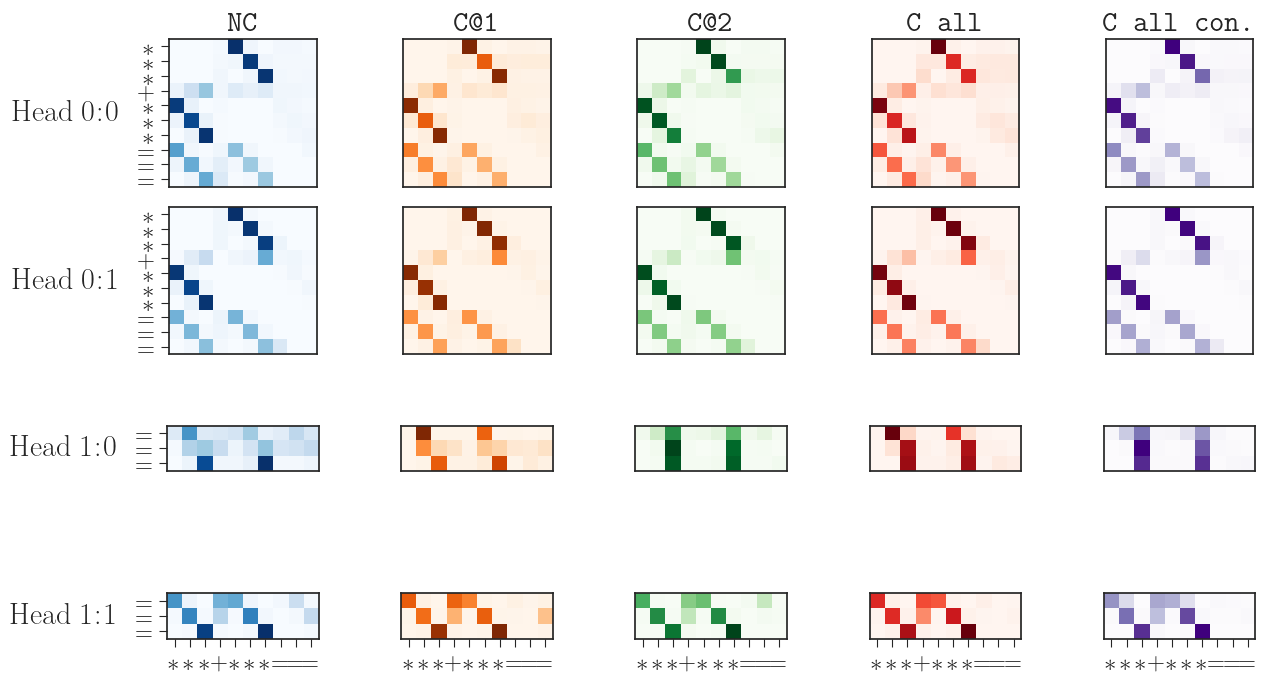

In [9]:
""" This outputs:

    1) PCA Analysis at output of Attention and MLP in each layer for the two leading axes. 
    
    2) Attention pattern per task (determined by where carried ones are needed)

    ### Keep in mind that SVD has a symmetry that flips the sign all singular left and right vectors. Which is why the figures below might be flipped compared to the ones in the text.
"""

### Specify model (out of six)

p = 2

### Ablation specification

## Attention 

M_apply = False
n_ab_head = []
# ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]]]
# ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[],[]]]
ab_headrow = []
ab_head = Q[0]

ablation_attention = [M_apply, n_ab_head, ab_head, ab_headrow]

## FFN

List_Neurons = []

ablation_ffn = List_Neurons

## Decoder 

n_ab_ffn = []
n_ab_att = []

ablation_decoder = [n_ab_att, n_ab_ffn]

ablations = [ablation_attention, ablation_ffn, ablation_decoder]

ix = torch.randint(len(data_f), size = (20000,))
data_ff = data_f[ix]
target_ff = target_f[ix]

mdd = 'model_n{!s}_s{!s}_w{!s}_{!s}'.format(n, s, w, p)
toLoad = directory + mdd

model = make_model(vocab, N = n, d_model = 128, d_ff = d_ff, h = 2, dropout=0.1, ablation_data=ablations)
model.load_state_dict(torch.load(toLoad, map_location='cpu'))
model.eval()

mask = None

out = model(data_ff.to('cpu'), mask)

Out_all = []
for l in range(n):

    Out_a = model.decoder.layers[l].out_a[:, :, :].detach().clone()
    Out_a = Out_a - Out_a.mean(0, keepdim=True)
    Out_all.append(Out_a)
    Out_f = model.decoder.layers[l].out[:, :, :].detach().clone()
    Out_f = Out_f - Out_f.mean(0, keepdim=True)
    Out_all.append(Out_f)


svd_full, positions, digit_ans_pos, digit_naive_ans_pos = svd(Out_all, data_ff, target_ff)

PCA_plot(n=n, svd_full=svd_full, positions=positions, digit_ans_pos=digit_ans_pos, digit_naive_ans_pos=digit_naive_ans_pos)

plot_attention_patterns(n=n, model=model, positions=positions)

In [10]:
""" This outputs:

    Accuracy per position and for each of the six models
"""

a = torch.tensor([])

for p in range(2, 3):

    ### Ablation specification

    ## Attention 

    M_apply = False
    n_ab_head = []  
    # ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]]]
    # ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[],[]]]
    ab_headrow = []
    ab_head = Q[0]

    ablation_attention = [M_apply, n_ab_head, ab_head, ab_headrow]

    ## FFN

    List_Neurons = []

    ablation_ffn = List_Neurons

    ## Decoder 

    n_ab_ffn = []
    n_ab_att = []

    ablation_decoder = [n_ab_att, n_ab_ffn]

    ablations = [ablation_attention, ablation_ffn, ablation_decoder]

    ix = torch.randint(len(data_f), size = (20000,))
    inputs = data_f[ix]
    targets = target_f[ix]

    mdd = 'model_n{!s}_s{!s}_w{!s}_{!s}'.format(n, s, w, p)
    toLoad = directory + mdd

    model = make_model(vocab, N = n, d_model = 128, d_ff = d_ff, h = 2, dropout=0.1, ablation_data=ablations)
    model.load_state_dict(torch.load(toLoad, map_location='cpu'))
    model.eval()

    # with torch.no_grad():
    #     for name, module in model.named_modules():
    #         if isinstance(module, nn.Linear):
    #             module.bias *= 0
    
    mask = None

    out = model(inputs, mask)

    a = torch.cat((a, (sum((torch.argmax(out[i, -3:, :].detach().to('cpu'), -1) == targets[i]).float() for i in range(len(inputs))) / len(inputs)).unsqueeze(0)), 0)
a

tensor([[1., 1., 1.]])

# For the claim about squashing just above section 4.1

In [ ]:
""" This outputs:

    Absolute value of cosine similarity between the hidden states for a given set of examples with fixed output 
    and computes the ratio between how much the overal similarity changes when going from attention output to MLP output
"""

### Ablation specification

## Attention 

M_apply = False
n_ab_head = []  
# ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]]]
# ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[],[]]]
ab_headrow = []
ab_head = Q[0]

ablation_attention = [M_apply, n_ab_head, ab_head, ab_headrow]

## FFN

List_Neurons = []

ablation_ffn = List_Neurons

## Decoder 

n_ab_ffn = []
n_ab_att = []

ablation_decoder = [n_ab_att, n_ab_ffn]

ablations = [ablation_attention, ablation_ffn, ablation_decoder]

ratio = []

for p in range(6):

    mdd = 'model_n{!s}_s{!s}_w{!s}_{!s}'.format(n, s, w, p)
    toLoad = directory + mdd

    model = make_model(vocab, N = n, d_model = 128, d_ff = d_ff, h = 2, dropout=0.1, ablation_data=ablations)
    model.load_state_dict(torch.load(toLoad, map_location='cpu'))
    model.eval()

    angle_att = Relative_Angle_AfterAttention(model, examples=examples, layer=1, All=False)
    angle_ffn = Relative_Angle_AfterFFN(model, examples=examples, layer=1, All =False)

    max_ffn = angle_ffn[:, :, -3:].view(-1, 3).max(0)[0]
    min_ffn = angle_ffn[:, :, -3:].view(-1, 3).min(0)[0]

    max_att = angle_att[:, :, -3:].view(-1, 3).max(0)[0]
    min_att = angle_att[:, :, -3:].view(-1, 3).min(0)[0]

    ratio.append(((max_ffn - min_ffn) / (max_att - min_att)).tolist())

ratio = torch.tensor(ratio)

ratio, ratio.mean(0), ratio.std(0), ratio.max(0)

# outputFile = directory + 'squashingATTtoFFN_layer1.data'
# fw = open(outputFile, 'wb')
# pickle.dump(ratio, fw)
# fw.close()

# For ablating entire MLP
# n = 2, s=0.3, w=0.2, p=range(6) -> Table 1 (right)
# n = 3, s=0.3, w=0.2, p=range(6) -> Table 2 

In [11]:
""" This outputs:

    Accuracy, non-corrected and corrected after ablating chosen part of network zero-ablated. 
    We correct answers manually to see whether the original ones where off by one either 
    by forgetting a carried one or adding one where it shouldnt have, this is the list vcorr. 
    This means: For non-carry over sums we subtract 1 from each position and when a carried one is needed we add it.  
"""

scores = torch.tensor([])

for p in range(6):

    mdd = 'model_n{!s}_s{!s}_w{!s}_{!s}'.format(n, s, w, p)
    toLoad = directory + mdd

    scores_z = torch.tensor([])

    for k in range(5):

        ix = torch.randint(len(data_f), size = (20000,))
        data_ff = data_f[ix]
        target_ff = target_f[ix]

        pos_nc = np.argwhere(sum((data_ff[:, j] + data_ff[:, j+4] >= 10) for j in range(3)) < 1)
        pos_c1 = np.argwhere((data_ff[:, 1] + data_ff[:, 1+4] >= 10) & (sum((data_ff[:, j] + data_ff[:, j+4] >= 10).float() for j in np.delete(np.arange(3), 1)) < 1))
        pos_c2 = np.argwhere((data_ff[:, 2] + data_ff[:, 2+4] >= 10) & (data_ff[:, 1] + data_ff[:, 5] < 9))
        pos_2c = np.argwhere(sum((data_ff[:, j] + data_ff[:, j+4] >= 10) for j in range(3)) == 2)
        pos_2cp = np.argwhere((data_ff[:, 1] + data_ff[:, 5] == 9) & (data_ff[:, 2] + data_ff[:, 6] >= 10))

        tasks_src = [data_ff[pos_nc[0]], data_ff[pos_c1[0]], data_ff[pos_c2[0]], data_ff[pos_2c[0]], data_ff[pos_2cp[0]]]
        tasks_tgt = [target_ff[pos_nc[0]], target_ff[pos_c1[0]], target_ff[pos_c2[0]], target_ff[pos_2c[0]], target_ff[pos_2cp[0]]]

        vcorr = [torch.tensor([1, 1, 1]), torch.tensor([-1, 1, 1]), torch.tensor([1, -1, 1]), torch.tensor([-1, -1, 1]), torch.tensor([-1, -1, 1])]

        inputs = tasks_src[k]
        targets = tasks_tgt[k]
        
        scores_p = torch.tensor([])

        for l in range(1):

            ### Ablation specification

            ## Attention 

            M_apply = False
            n_ab_head = []
            # ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]]]
            # ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[],[]]]
            ab_headrow = []
            ab_head = Q[0]

            ablation_attention = [M_apply, n_ab_head, ab_head, ab_headrow]

            ## FFN

            List_Neurons = []

            ablation_ffn = List_Neurons

            ## Decoder 

            n_ab_ffn = [1]
            n_ab_att = []

            ablation_decoder = [n_ab_att, n_ab_ffn]

            ablations = [ablation_attention, ablation_ffn, ablation_decoder]

            model = make_model(vocab, N = n, d_model = 128, d_ff = d_ff, h = 2, dropout=0.1, ablation_data=ablations)
            model.load_state_dict(torch.load(toLoad, map_location='cpu'))
            model.eval()

            mask = None
            out = model(inputs, mask)

            pre = torch.argmax(out[:, -3:, :].detach().to('cpu'), -1)

            bp = sum((pre[i] == targets[i]).float() for i in range(len(inputs))) / len(inputs)

            bcorr = sum(((pre[i] - vcorr[k]) % 10 == targets[i]).float() for i in range(len(inputs))) / len(inputs)

            scores_p = torch.cat((scores_p, torch.cat((bp.unsqueeze(0), bcorr.unsqueeze(0)), 0)), 0)
            
        scores_z = torch.cat((scores_z, scores_p.unsqueeze(0)), 0)  

    scores = torch.cat((scores, scores_z.unsqueeze(0)), 0)

scores.mean(0)

tensor([[[0.9047, 0.9510, 0.9626],
         [0.0953, 0.0490, 0.0374]],

        [[0.1388, 0.9933, 0.9579],
         [0.8612, 0.0067, 0.0421]],

        [[0.8923, 0.1010, 0.9909],
         [0.1077, 0.8990, 0.0091]],

        [[0.1445, 0.0072, 0.9891],
         [0.8555, 0.9928, 0.0109]],

        [[0.1215, 0.0000, 0.9894],
         [0.8777, 1.0000, 0.0106]]])

# For ablating decision heads
# n = 2, s=0.3, w=0.2, p=range(6) -> Table 1 (left)

In [ ]:
""" This outputs:

    Accuracy, non-corrected and corrected after ablating decision heads. 
    We correct answers manually to see whether the original ones where off by one either 
    by forgetting a carried one or adding one where it shouldnt have, this is the list vcorr. 
    This means: For non-carry over sums we subtract 1 from each position and when a carried one is needed we add it.  
"""

scores = torch.tensor([])

for p in range(6):

    mdd = 'model_n{!s}_s{!s}_w{!s}_{!s}'.format(n, s, w, p)
    toLoad = directory + mdd

    scores_z = torch.tensor([])

    for k in range(5):

        ix = torch.randint(len(data_f), size = (20000,))
        data_ff = data_f[ix]
        target_ff = target_f[ix]

        pos_nc = np.argwhere(sum((data_ff[:, j] + data_ff[:, j+4] >= 10) for j in range(3)) < 1)
        pos_c1 = np.argwhere((data_ff[:, 1] + data_ff[:, 1+4] >= 10) & (sum((data_ff[:, j] + data_ff[:, j+4] >= 10).float() for j in np.delete(np.arange(3), 1)) < 1))
        pos_c2 = np.argwhere((data_ff[:, 2] + data_ff[:, 2+4] >= 10) & (data_ff[:, 1] + data_ff[:, 5] < 9))
        pos_2c = np.argwhere(sum((data_ff[:, j] + data_ff[:, j+4] >= 10) for j in range(3)) == 2)
        pos_2cp = np.argwhere((data_ff[:, 1] + data_ff[:, 5] == 9) & (data_ff[:, 2] + data_ff[:, 6] >= 10))

        tasks_src = [data_ff[pos_nc[0]], data_ff[pos_c1[0]], data_ff[pos_c2[0]], data_ff[pos_2c[0]], data_ff[pos_2cp[0]]]
        tasks_tgt = [target_ff[pos_nc[0]], target_ff[pos_c1[0]], target_ff[pos_c2[0]], target_ff[pos_2c[0]], target_ff[pos_2cp[0]]]

        vcorr = [torch.tensor([1, 1, 1]), torch.tensor([-1, 1, 1]), torch.tensor([1, -1, 1]), torch.tensor([-1, -1, 1]), torch.tensor([-1, -1, 1])]

        inputs = tasks_src[k]
        targets = tasks_tgt[k]
        
        scores_p = torch.tensor([])

        for l in range(2):

            ### Ablation specification

            ## Attention 

            M_apply = False
            n_ab_head = [1]
            # ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]]]
            # ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[],[]]]
            ab_headrow = []
            ab_head = Q[l+1]

            ablation_attention = [M_apply, n_ab_head, ab_head, ab_headrow]

            ## FFN

            List_Neurons = []

            ablation_ffn = List_Neurons

            ## Decoder 

            n_ab_ffn = []
            n_ab_att = []

            ablation_decoder = [n_ab_att, n_ab_ffn]

            ablations = [ablation_attention, ablation_ffn, ablation_decoder]

            model = make_model(vocab, N = n, d_model = 128, d_ff = d_ff, h = 2, dropout=0.1, ablation_data=ablations)
            model.load_state_dict(torch.load(toLoad, map_location='cpu'))
            model.eval()

            mask = None
            out = model(inputs, mask)

            pre = torch.argmax(out[:, -3:, :].detach().to('cpu'), -1)

            bp = sum((pre[i] == targets[i]).float() for i in range(len(inputs))) / len(inputs)

            bcorr = sum(((pre[i] - vcorr[k]) % 10 == targets[i]).float() for i in range(len(inputs))) / len(inputs)

            scores_p = torch.cat((scores_p, torch.cat((bp.unsqueeze(0), bcorr.unsqueeze(0)), 0)), 0)
            
        scores_z = torch.cat((scores_z, scores_p.unsqueeze(0)), 0)  

    scores = torch.cat((scores, scores_z.unsqueeze(0)), 0)

imp_att = torch.tensor([])
imp_heads = [1, 0, 0, 0, 0, 1] # The decisions heads
for j in range(6):
    hj = 1 - imp_heads[j]
    imp_att = torch.cat((imp_att, scores[j, :, (2*hj):(2*hj+2), :].unsqueeze(0)), 0)
imp_att.mean(0)

# For the dissection claims in section 5.1 and appendix C.4
# n = 2, s=0.3, w=0.2, p = 2 -> section 5.1
# n = 2, s=0.1, w=0.2, p = 0, 2, 3 (can handle full ablation, p=1,4,5 can not) -> appendix C.4
# n = 2, s=0.2, w=1.0, p = 0, d_ff = 512 -> Table 3

In [ ]:
"""     
    Dissecting the MLP and computing the accuracy after ablating a specific set of Neurons (List_Neurons)
    We go through the data twice first to find the relevant Neurons and then to rerun the model with those 
    neurons zero-ablated. 

    This outputs: accuracy after ablation and the list of Neurons that were ablated.
"""

List_Neurons = []

p = 3

mdd = 'model_n{!s}_s{!s}_w{!s}_{!s}'.format(n, s, w, p)
toLoad = directory + mdd

N_abl = []

for i in range(2):

    ### Ablation specification

    ## Attention 

    M_apply = False
    n_ab_head = []
    # ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]]]
    # ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[],[]]]
    ab_headrow = []
    ab_head = Q[0]

    ablation_attention = [M_apply, n_ab_head, ab_head, ab_headrow]

    ## FFN

    ablation_ffn = List_Neurons

    ## Decoder 

    n_ab_ffn = []
    n_ab_att = []

    ablation_decoder = [n_ab_att, n_ab_ffn]

    ablations = [ablation_attention, ablation_ffn, ablation_decoder]

    model = make_model(vocab, N = n, d_model = 128, d_ff = d_ff, h = 2, dropout=0.1, ablation_data=ablations)
    model.load_state_dict(torch.load(toLoad, map_location='cpu'))
    model.eval()

    ix = torch.randint(len(data_f), size = (20000,))
    data_ff = data_f[ix]
    target_ff = target_f[ix]

    pos_nc = np.argwhere(sum((data_ff[:, j] + data_ff[:, j+4] >= 10) for j in range(3)) < 1)
    pos_c1 = np.argwhere((data_ff[:, 1] + data_ff[:, 1+4] >= 10) & (sum((data_ff[:, j] + data_ff[:, j+4] >= 10).float() for j in np.delete(np.arange(3), 1)) < 1))
    pos_c2 = np.argwhere((data_ff[:, 2] + data_ff[:, 2+4] >= 10) & (data_ff[:, 1] + data_ff[:, 5] < 9))
    pos_2c = np.argwhere(sum((data_ff[:, j] + data_ff[:, j+4] >= 10) for j in range(3)) == 2)
    pos_2cp = np.argwhere((data_ff[:, 1] + data_ff[:, 5] == 9) & (data_ff[:, 2] + data_ff[:, 6] >= 10))

    tasks_src = [data_ff[pos_nc[0]], data_ff[pos_c1[0]], data_ff[pos_c2[0]], data_ff[pos_2c[0]], data_ff[pos_2cp[0]]]
    tasks_tgt = [target_ff[pos_nc[0]], target_ff[pos_c1[0]], target_ff[pos_c2[0]], target_ff[pos_2c[0]], target_ff[pos_2cp[0]]]

    vcorr = [torch.tensor([1, 1, 1]), torch.tensor([-1, 1, 1]), torch.tensor([1, -1, 1]), torch.tensor([-1, -1, 1]), torch.tensor([-1, -1, 1])]

    a = torch.tensor([])
    z_out = []
    for k in range(len(tasks_src)):

        inputs = tasks_src[k]
        targets = tasks_tgt[k]

        mask = None

        out = model(inputs, mask)

        ap = sum((torch.argmax(out[i, -3:, :].detach().to('cpu'), -1) == targets[i]).float() for i in range(len(inputs))) / len(inputs)

        acorr = sum(((torch.argmax(
                        out[i, -3:, :].detach().to('cpu'), -1) - vcorr[k]) % 10 == targets[i]).float() for i in range(len(inputs))) / len(inputs)

        a = torch.cat((a, torch.cat((ap.unsqueeze(0), acorr.unsqueeze(0)), 0)), 0)

        z = model.decoder.layers[n-1].ffn.out[:, -3:, :].mean(0).clone().detach()[0]
        z_out.append(z)
    Neur = []
    for i in range(1, 5):  
        zg = torch.argwhere(z_out[i] > z_out[0]).squeeze(-1)
        for j in range(len(zg)):
            if zg[j] not in Neur:
                Neur.append(zg[j].item())
    List_Neurons = Neur
    N_abl.append(torch.tensor(List_Neurons))
a, N_abl

# SVD Analysis for pre-activation weights
# n=2, s=0.2, w=1.0, d_ff =512, p = 0, number_most_active_neurons = 256 -> Figure 13
# n=2, s=0.3, w=0.2, p = 2, number_most_active_neurons = 64 -> Figure 14

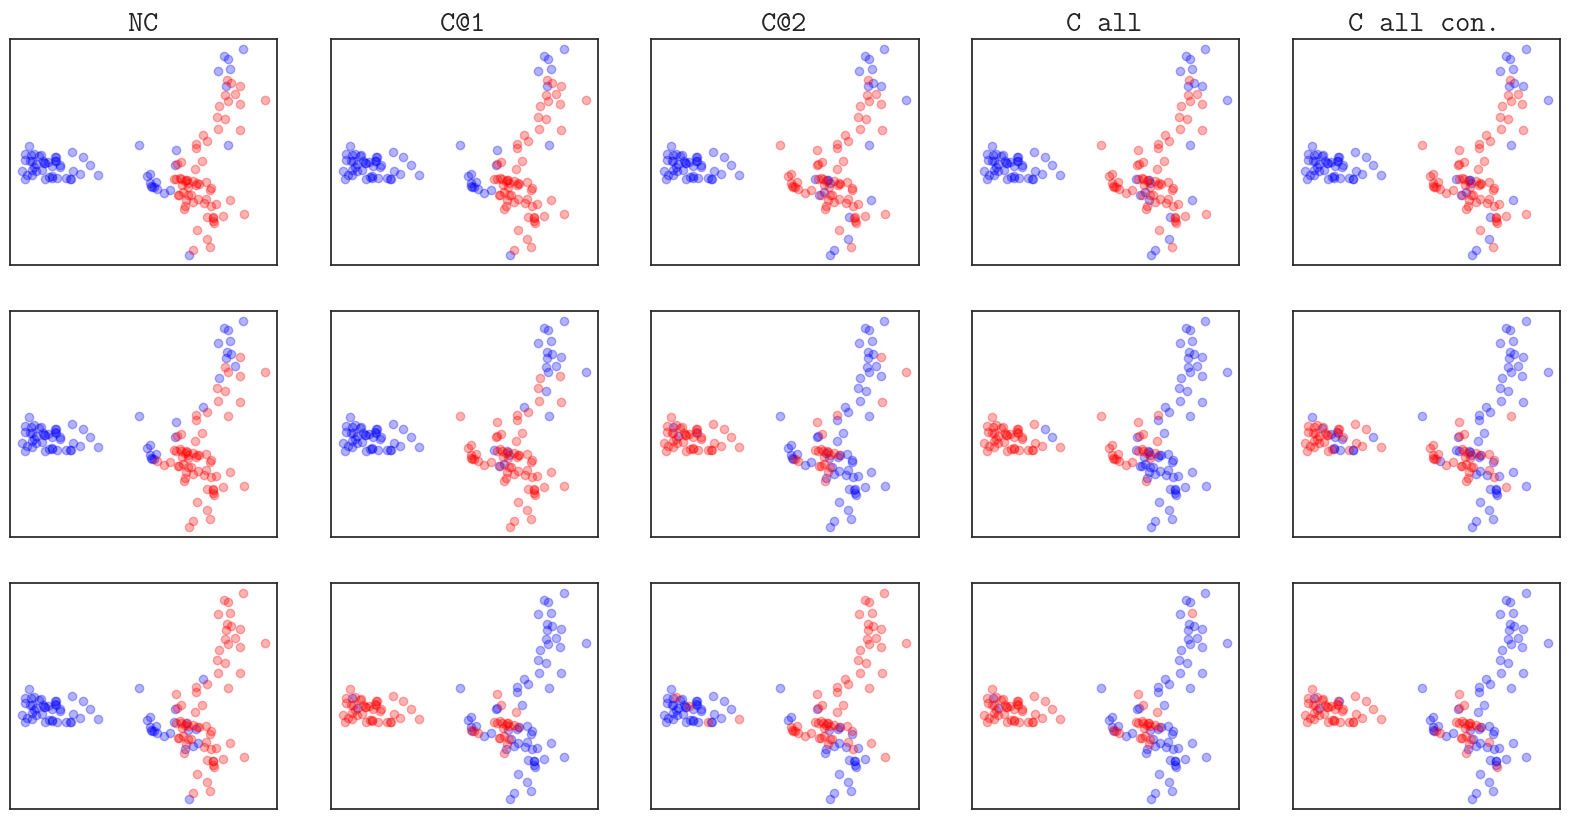

In [12]:
"""
    This generates a scatter plot of most active neurons for a given task and position.

"""

p = 2
number_most_active_neurons = 64

mdd = 'model_n{!s}_s{!s}_w{!s}_{!s}'.format(n, s, w, p)
toLoad = directory + mdd

### Ablation specification

## Attention 

M_apply = False
n_ab_head = []
# ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]]]
# ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[],[]]]
ab_headrow = []
ab_head = Q[0]

ablation_attention = [M_apply, n_ab_head, ab_head, ab_headrow]

## FFN

ablation_ffn = List_Neurons

## Decoder 

n_ab_ffn = []
n_ab_att = []

ablation_decoder = [n_ab_att, n_ab_ffn]

ablations = [ablation_attention, ablation_ffn, ablation_decoder]

model = make_model(vocab, N = n, d_model = 128, d_ff = d_ff, h = 2, dropout=0.1, ablation_data=ablations)
model.load_state_dict(torch.load(toLoad, map_location='cpu'))
model.eval()

MLP = model.decoder.layers[1].ffn.w1.weight.clone().detach()
svd_mlp = torch.svd(MLP)


ix = torch.randint(len(data_f), size = (20000,))
data_ff = data_f[ix]
target_ff = target_f[ix]

digit_ans_pos = []
for k in range(3):
    ans_pp = []
    for i in range(10):
        ans_p = []
        for j in range(len(target_ff)):
            if target_ff[j, k] == i:
                ans_p.append(j)
        ans_pp.append(torch.tensor(ans_p))
    digit_ans_pos.append(ans_pp)

pos_nc = np.argwhere(sum((data_ff[:, j] + data_ff[:, j+4] >= 10) for j in range(3)) < 1)[0]
pos_c1 = np.argwhere((data_ff[:, 1] + data_ff[:, 1+4] >= 10) & (sum((data_ff[:, j] + data_ff[:, j+4] >= 10).float() for j in np.delete(np.arange(3), 1)) < 1))[0]
pos_c2 = np.argwhere((data_ff[:, 2] + data_ff[:, 2+4] >= 10) & (data_ff[:, 1] + data_ff[:, 5] < 9))[0]
pos_2c = np.argwhere(sum((data_ff[:, j] + data_ff[:, j+4] >= 10) for j in range(3)) == 2)[0]
pos_2cp = np.argwhere((data_ff[:, 1] + data_ff[:, 5] == 9) & (data_ff[:, 2] + data_ff[:, 6] >= 10))[0]

positions = [pos_nc, pos_c1, pos_c2, pos_2c, pos_2cp]

out = model(data_ff, None)

z_out = []
for k in range(3): 
    z_out_p = []
    for i in range(10):
        z = model.decoder.layers[1].ffn.out[digit_ans_pos[k][i], 7+k, :].clone().detach()
        z_out_p.append(z)
    z_out.append(z_out_p)

z_out_n = []
for k in range(3): 
    z_out_p = []
    for i in range(len(positions)):
        z = model.decoder.layers[1].ffn.out[positions[i], 7+k, :].clone().detach()
        z_out_p.append(z)
    z_out_n.append(z_out_p)

def counter(a):
    b = a.sort(descending=True)[0]
    s = []
    j = 1
    for i in range(b.shape[0]-1):
        if (b[i] > b[i+1]) and (i != b.shape[0] - 2):
            s.append([b[i], j])
            j = 1
        elif i == b.shape[0] - 2:
            s.append([b[i], j + 1])
        elif b[i] == b[i+1]: 
            j += 1
        
    return torch.tensor(s)

fig, ax = plt.subplots(3, 5, figsize=(20, 10))

for k in range(3):
    for j in range(len(positions)):
        zz = torch.argwhere(z_out_n[k][j] != 0)[:, 1]

        s_ = counter(zz)
        sp = s_[s_[:, 1].sort(descending=True)[1]][:number_most_active_neurons, 0]

        zzpos = list(set(sp.tolist()))
        notzzpos = list(set(range(d_ff)) - set(zzpos))
       
        a, b = 0, 1

        x = svd_mlp[0][notzzpos, a] * svd_mlp[1][a]
        y = svd_mlp[0][notzzpos, b] * svd_mlp[1][b]

        ax[2-k, j].scatter(x, y, alpha=0.3, color='blue')

        x = svd_mlp[0][zzpos, a] * svd_mlp[1][a]
        y = svd_mlp[0][zzpos, b] * svd_mlp[1][b]

        ax[2-k, j].scatter(x, y, alpha=0.3, color='red')
        ax[2-k, j].set_yticks([])
        ax[2-k, j].set_xticks([])

        # x = svd1[0][L, a] * svd1[1][a]
        # y = svd1[0][L, b] * svd1[1][b]

        # ax[j, k].scatter(x, y, alpha=0.3, color='black', marker='x')

    ax[0, 0].set_title('$\\texttt{NC}$')
    ax[0, 1].set_title('$\\texttt{C@1}$')
    ax[0, 2].set_title('$\\texttt{C@2}$')
    ax[0, 3].set_title('$\\texttt{C all}$')    
    ax[0, 4].set_title('$\\texttt{C all con.}$')

# n=2, s=0.3, w=0.2, p=0 -> Figure 17

In [ ]:
""" This outputs:

    1) PCA Analysis at output of Attention and MLP in each layer for the two leading axes. 
    
    ### Keep in mind that SVD has a symmetry that flips the sign all singular left and right vectors. Which is why the figures below might be flipped compared to the ones in the text.
"""

### Specify model (out of six)

p = 0

### Ablation specification

## Attention 

M_apply = False
n_ab_head = []
# ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]], [[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]]]
# ab_headrow = [[[7, 8, 9], [7, 8, 9]], [[],[]]]
ab_headrow = []
ab_head = Q[0]

ablation_attention = [M_apply, n_ab_head, ab_head, ab_headrow]

## FFN

List_Neurons = []

ablation_ffn = List_Neurons

## Decoder 

n_ab_ffn = []
n_ab_att = []

ablation_decoder = [n_ab_att, n_ab_ffn]

ablations = [ablation_attention, ablation_ffn, ablation_decoder]

ix = torch.randint(len(data_f), size = (20000,))
data_ff = data_f[ix]
target_ff = target_f[ix]

mdd = 'model_n{!s}_s{!s}_w{!s}_{!s}'.format(n, s, w, p)
toLoad = directory + mdd

model = make_model(vocab, N = n, d_model = 128, d_ff = d_ff, h = 2, dropout=0.1, ablation_data=ablations)
model.load_state_dict(torch.load(toLoad, map_location='cpu'))
model.eval()

mask = None

out = model(data_ff.to('cpu'), mask)

Out_all = []
for l in range(n):

    Out_a = model.decoder.layers[l].out_a[:, :, :].detach().clone()
    Out_a = Out_a - Out_a.mean(0, keepdim=True)
    Out_all.append(Out_a)
    Out_f = model.decoder.layers[l].out[:, :, :].detach().clone()
    Out_f = Out_f - Out_f.mean(0, keepdim=True)
    Out_all.append(Out_f)


svd_full, positions, digit_ans_pos, digit_naive_ans_pos = svd(Out_all, data_ff, target_ff)

PCA_plot_different(n=n, svd_full=svd_full, positions=positions, digit_ans_pos=digit_ans_pos, carry_or_non_carry_at_pos_8=True)
PCA_plot_different(n=n, svd_full=svd_full, positions=positions, digit_ans_pos=digit_ans_pos, carry_or_non_carry_at_pos_8=False)